### Introduction

We have time matched PK (ME-2) and biomarker data (fxa) with 8 subjects per dose group in 10 dose groups.

We will incorporate intraindividual variation as an element in the model, but to keep it simple this is only applied to EC50 parameter.

We will model the drug concentration effect curves with a direct action PK/PD model with some element of intraindividual variation. The core model sigmoid emax model, with residual variation in the form of a normal distrintion and a single interindividual random effect applied to EC50, which will be described as a log normal distribution.

At the end we will have modelled the PK Biomarker relationships for each individual.


In [1]:
from pymc3 import Model, autocorrplot, Normal, Lognormal, sample_ppc, Uniform, traceplot, df_summary, trace_to_dataframe,find_MAP, NUTS, sample, summary
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
data = pd.read_csv('fxa.data.csv' )

In [3]:
data.head()

,subject,weight,age,gender,time,dose,cobs,fxa.inh.obs
0,1,59,30,0,0.000,1.25,0.00,2.78
1,1,59,30,0,0.083,1.25,6.19,15.20
2,1,59,30,0,0.167,1.25,13.20,9.16
3,1,59,30,0,0.250,1.25,15.30,13.70
4,1,59,30,0,0.500,1.25,22.30,21.50


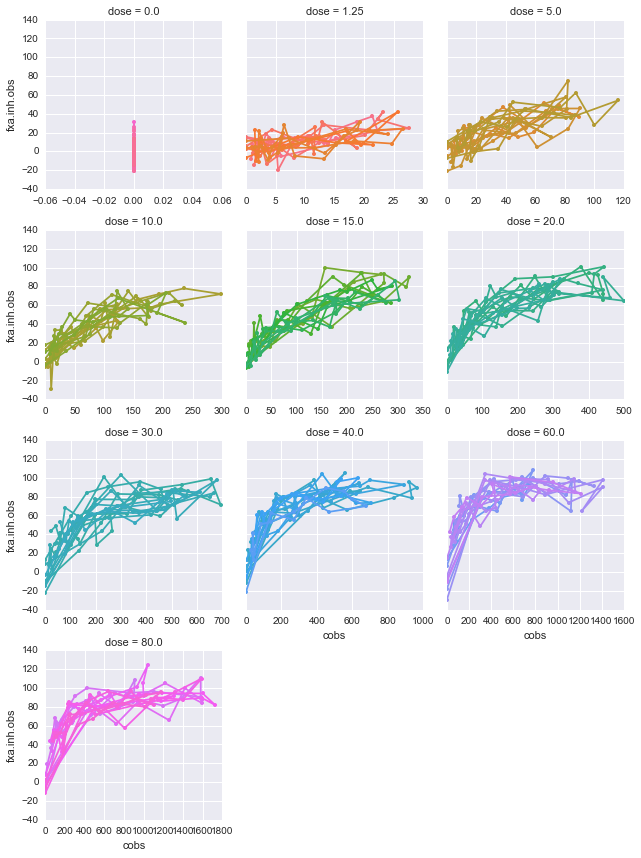

In [4]:
relationship = sns.FacetGrid(data, col="dose",hue ="subject" ,col_wrap=3, size=3, sharex=False)
relationship.map(plt.plot, "cobs", "fxa.inh.obs", marker="o", ms=4)

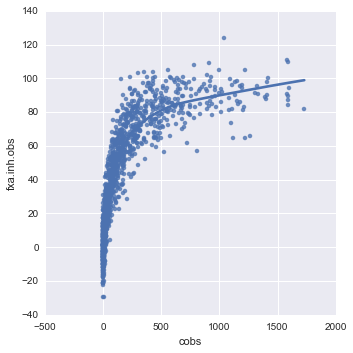

In [5]:
sns.lmplot(x="cobs", y="fxa.inh.obs", data=data, lowess=True)

### Create the arrays to pass into the model from the data dataframe

In [6]:
fxa = np.array(data['fxa.inh.obs'])
cobs = np.array(data.cobs)
dose = np.array(data.dose)

# These variables are used to specify the model parameters that
n_patients = len(data['subject'].unique())
subject = data['subject'].values-1


### Create the model

In [16]:
pkpd_model = Model()

with pkpd_model:

    # Hyperparameter Priors 

    omega_ec50 = Uniform('omega_ec50', lower =0, upper =10) 
    mu_ec50 = Lognormal ('mu_ec50', mu =0, tau = 6)

    emax = Uniform('emax', lower=0, upper =100)   
    gamma = Uniform('gamma', lower=0, upper=10)
    
    sigma = Uniform ('sigma', lower =0, upper =100)  
    
    ec50 = Lognormal('ec50', mu=mu_ec50, tau = omega_ec50, shape = n_patients)  
 
    # Expected value of outcome
    fxaMean = (emax*(cobs**gamma)) / ((ec50[subject]**gamma) + (cobs**gamma))
    
    # Likelihood (sampling distribution) of observations
    effect = Normal('effect', mu=fxaMean, sd =sigma, observed =fxa)
    effect_pred = Normal('effect_pred', mu=fxaMean, sd =sigma, shape =len(cobs))

Applied interval-transform to omega_ec50 and added transformed omega_ec50_interval to model.
Applied log-transform to mu_ec50 and added transformed mu_ec50_log to model.
Applied interval-transform to emax and added transformed emax_interval to model.
Applied interval-transform to gamma and added transformed gamma_interval to model.
Applied interval-transform to sigma and added transformed sigma_interval to model.
Applied log-transform to ec50 and added transformed ec50_log to model.


### Initiate the sampling

In [81]:
with pkpd_model:

    # obtain starting values via MAP
    start = find_MAP()
    
    # draw 2000 posterior samples
    trace = sample(2000,  start=start) 

Assigned NUTS to omega_ec50_interval
Assigned NUTS to mu_ec50_log
Assigned NUTS to emax_interval
Assigned NUTS to gamma_interval
Assigned NUTS to sigma_interval
Assigned NUTS to ec50_log
Assigned NUTS to effect_pred
 [-----------------100%-----------------] 2000 of 2000 complete in 60.4 sec

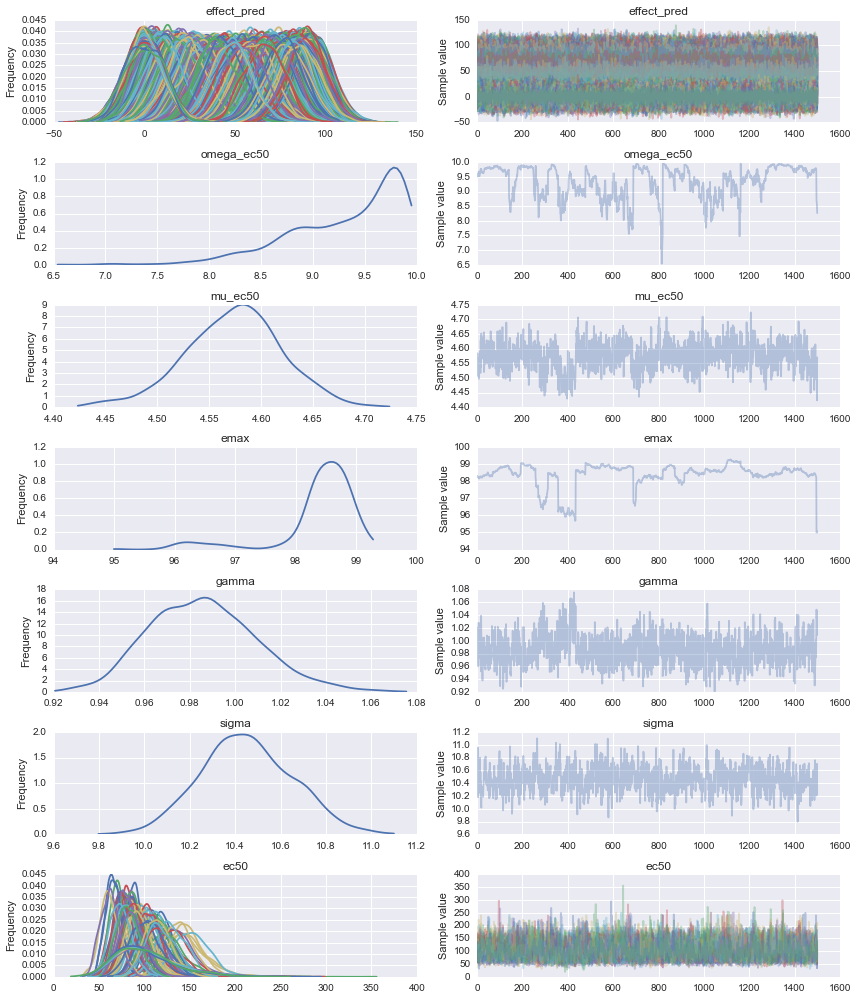

In [82]:
t=traceplot(trace[500:])

### Lets plot out the posterior predicted values for each value of cobs to get a feel for the model fit - a rough posterior predictive check

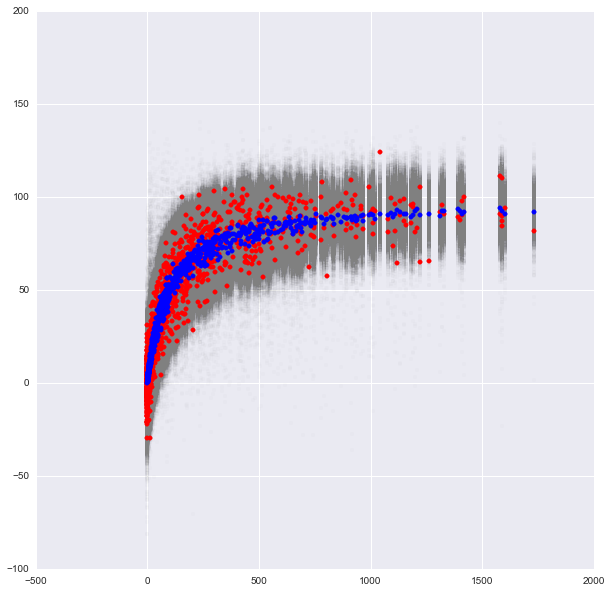

In [83]:
t_df = trace_to_dataframe(trace)
filter_col = [col for col in list(t_df) if col.startswith('effect_pred__')]
col= pd.DataFrame()
to_col =pd.DataFrame()

for n, cols in enumerate(filter_col):
        to_col['effect_pred']=t_df[cols]
        to_col['cobs'] = cobs[n]
        col = pd.concat([col, to_col])
        
plt.figure(figsize=(10,10))
plt.scatter(col['cobs'], col['effect_pred'], alpha =0.02, s= 15 ,color ='grey')
plt.scatter(data.cobs, data['fxa.inh.obs'], alpha =1, color='red')
means = col.groupby('cobs', as_index=False).aggregate(np.mean)
plt.scatter(means.cobs, means['effect_pred'], color='blue')
#plt.axis([-10, 100, 0, 15])

Looks pretty good

### Plot out the individual predictions for each dose level

In [84]:
col= np.empty([1,6])

for n, cols in enumerate(filter_col):

        a = subject[n]+1
        b = dose[n]
        c = cobs[n]
        d = t_df[cols].quantile(q=0.5)
        e = t_df[cols].quantile(q=0.95)
        f = t_df[cols].quantile(q=0.05)        
        g = np.array([a,b,c,d,e,f]).reshape(1,6)
        col = np.concatenate((col,g)) 
        
col = np.delete(col, (0), axis=0)
col = pd.DataFrame(col, columns=['subject', 'dose', 'cobs', 'mean', 'max', 'min'])
col = col.sort_index(by=['subject', 'cobs'])

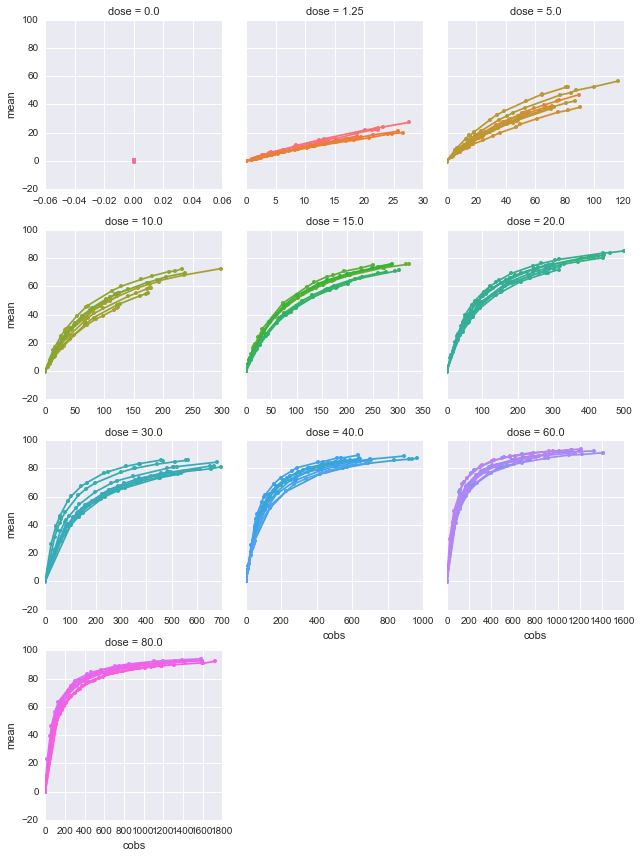

In [85]:
effect = sns.FacetGrid(col, col="dose",hue ="subject" ,col_wrap=3, size=3, sharex=False)
effect.map(plt.plot, "cobs", "mean", marker="o", ms=4)
#effect.map(plt.plot, "cobs", "max", linestyle ='--')
#effect.map(plt.plot, "cobs", "min", linestyle ='--')